# Fractal in Biology (West 1997)

This notebook checks the result in [West, et al. (1997)](https://www.science.org/doi/10.1126/science.276.5309.122). This paper concludes that fractal in biology results in the minimization of total energy cost. In the specific case considered by the authors, the mammalian circulatory systems, the fractal branching of capillary vessel naturally arises from reducing the energy cost of vessel circulation. Here, we check this result by numerical optimization method.

## Notations

We follow the notations:

- $C$: number of branching levels.
- $k$: branching level, from $0$ to $C$.
- $n_k$: number of branches at $k$ level.
- $r_k$: radius of vessel at $k$ level.
- $l_k$: length of vessel at $k$ level.
- $\nu_k$: $n_{k+1} / n_k$.
- $\rho_k$: $r_{k+1} / r_k$.
- $\lambda_k$: $l_{k+1} / l_k$.

## Assumptions

The assumption that the properties of capillary are universal for all mammals implies that the $n_C$, $l_C$, and $r_C$ are fixed. So, we have

$$ l_k = \frac{l_k}{l_{k+1}} \cdots \frac{l_{C-1}}{l_C} l_C = l_C \lambda_k^{-1} \cdots \lambda_{C-1}^{-1} = l_C \prod_{i=k}^{C-1} \lambda_i^{-1}. $$

The same,

$$ r_k = r_C \prod_{i=k}^{C-1} \rho_i^{-1}, $$

  and

$$ n_k = n_C \prod_{i=k}^{C-1} \nu_i^{-1}. $$

Based on assumption of area-preserving, we have that $n_k r_k^2$ is independent of $k$. This implies

$$ \rho_k = \nu_k^{-1/2}. $$

And by assumption of space-fulfilling, we have that $n_k l_k^3$ is independent of $k$. This implies

$$ \lambda_k = \nu_k^{-1/3}. $$

Because of these, the unique degree of freedom is the $\nu$.

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import logsumexp
import matplotlib.pyplot as plt

We use several samples in searching optimal parallelly. So, the $\nu$, or for numerical stability $\ln \nu$, has tensor shape `[samples, levels]`.

In [2]:
LEVELS = 10

## Loss Function

The quantity to be minimized is the total resistance of the vessel system. By [Hagen-Poiseuille equation](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation#Equation), we have the difference of pressure at level $k$, $\Delta p_k = Q_k R_k$ where $Q_k$ represents the flow rate and $R_k := (8 \mu l_k)/(\pi r_k^4)$. Analogy to electricity, $\Delta p_k$ corresponds to difference of potential $\Delta V$, and $Q_k$ to current $I$. So, the $R_k$ is the resistance. At level $k$, the vessels are parallel. And for different levels, vessels are serial. So, the total resistance comes to be

$$ R_b = \sum_{k=0}^{C} \frac{R_k}{n_k} = \frac{8\mu}{\pi} \sum_{k=0}^{C} \frac{l_k}{r_k^4 n_k} = \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \sum_{k=0}^{C} \prod_{i=k}^{C-1} \frac{\rho_i^4 \nu_i}{\lambda_i}. $$

Plugging into the relation between $\rho$, $\lambda$ and $\nu$, we find

$$ R_b = \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \sum_{k=0}^{C} \prod_{i=k}^{C-1} \nu_i^{-2/3}. $$

For numerical stability, we consider

$$ \ln R_b = \ln \left( \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \right) + \ln \sum_{k=0}^{C} \prod_{i=k}^{C-1} \nu_i^{-2/3}. $$

In [3]:
def get_log_resistance(log_nu):
    """Omit the constant."""
    logits = np.stack([
        -(2/3) * np.sum(log_nu[k:]) for k in range(LEVELS+1)
    ])
    return logsumexp(logits)


log_nu = np.log(2) * np.ones([LEVELS])
get_log_resistance(log_nu)

0.9879254996304317

It is also assumed that the blood volume is proportional to the body size. The blood volumne is given by

$$ V_b = \pi \sum_{k=0}^C r_k^2 l_k n_k = \pi r_C^2 l_C n_C \sum_{k=0}^C \prod_{i=k}^{C-1} \frac{1}{\rho_i^2 \lambda_i \nu_i} = \pi r_C^2 l_C n_C \sum_{k=0}^C \prod_{i=k}^{C-1} \nu_i^{1/3}. $$

If the body size is fixed, then $V_b$ shall be fixed too. Then,

$$ \ln V_b = \ln \left( \pi r_C^2 l_C n_C \right) + \ln \sum_{k=0}^C \prod_{i=k}^{C-1} \nu_i^{1/3}. $$

In [4]:
def get_log_volume(log_nu):
    """Omit the constant."""
    logits = np.stack([
        (1/3) * np.sum(log_nu[k:]) for k in range(LEVELS+1)
    ])
    return logsumexp(logits)

get_log_volume(log_nu)

3.8068985310703907

Since $n_{k+1} \ge n_k$, $\nu_k$ shall be greater than unit. So, there is another constraint that, for each $k$,

$$ \ln \nu_k \ge 0. $$

Altogether, the loss function shall be

$$ \ln R_b(\nu) + \mu \left( \ln V_b(\nu) - \ln \bar{V}_b \right) + \sum_{k=1}^{C-1} \omega_k \left( \ln \nu_k - z_k^2 \right), $$

for some observed values $\bar{V}_b$ given.

What is a proper value of $\bar{V}_b$. It is natural to suppose that $n_{k+1}/n_k \ge 2$. This means $\bar{V}_b$ shall be greater than the volume given by $\nu = 2$.

In fact, it is sufficient for the optimized volume to approximate the order of $\bar{V}_b$. We can regard this optimized volume as the real $\bar{V}_b$. In other words, $\bar{V}_b$ is used to determine the order, but not the accurate value.

In [5]:
least_log_volume = get_log_volume(np.log(2) * np.ones([LEVELS]))
least_log_volume

3.8068985310703907

In [6]:
TRUE_LOG_VOLUME = 5e+2

## Optimization

In [7]:
initial_values = [np.random.uniform(3., 5.) for _ in range(LEVELS)]
bounds = [(0., None) for _ in range(LEVELS)]
constraints = [
    {
        'type': 'eq',
        'fun': lambda log_nu: get_log_volume(log_nu) - TRUE_LOG_VOLUME,
    },
]
result = minimize(
    get_log_resistance,
    initial_values,
    bounds=bounds,
    constraints=constraints,
    tol=1e-40,
    options={'maxiter': 1000},
)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 1.038e+02  1.424e+02  1.535e+02  1.574e+02  1.562e+02
            1.572e+02  1.572e+02  1.565e+02  1.582e+02  1.575e+02]
     nit: 5
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 56
    njev: 5

In [8]:
optimized_log_nu = result.x

Let us check the optimization results:

In [9]:
get_log_resistance(optimized_log_nu), get_log_volume(optimized_log_nu)

(0.0, 500.0)

It is strange that the `minimize` does not give the true extreme!

In [18]:
test_log_nu = [0., 0., 0., 0., 0., 0., 0., 0., 0., 1500.]  # the true extreme.
get_log_resistance(test_log_nu), get_log_volume(test_log_nu)

(0.0, 502.30258509299404)

So the true extreme should be:

In [19]:
optimized_log_nu = test_log_nu

And for checking fractal:

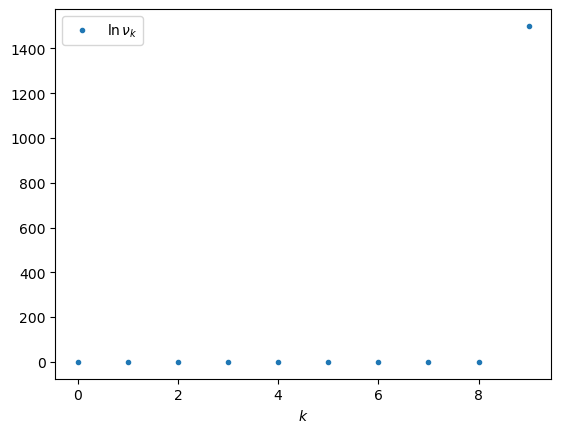

In [20]:
plt.plot(optimized_log_nu, '.', label='$\\ln \\nu_k$')
# plt.plot(np.exp(optimized_log_nu), '.', label='$\\nu_k$')
plt.xlabel('$k$')
plt.legend()
plt.show()

Fractal does not emerge. The reason is that the leading term in $R_b$ is not permutation symmetric on all $\nu_k$.

Now, we can see how many branches there are. Notice that

$$ \frac{n_c}{n_1} = \frac{n_C}{n_{C-1}} \cdots \frac{n_2}{n_1} = \prod_{k=1}^{C-1} \nu_k, $$

and that $n_1 = 1$, we find

$$ n_c = \prod_{k=1}^{C-1} \nu_k. $$

In [13]:
def get_log_nc(log_nu):
    return np.sum(log_nu)

get_log_nc(optimized_log_nu)

1500.0

## Conclusion

In the paper of West, et al (1997), the fractal structure is "analytically derived". But, as we have numerically tested here, when the `TRUE_LOG_VOLUME` is not large enough, fractal structure will not appear. Instead, it will have a single branching, that is, all $\nu_k$ except for one are unit.

Even when the `TRUE_LOG_VOLUME` is large, fractal does not emerge. It is observed that $n_{C-1} \gg n_k$ for any $k < C-1$. This is because the leading term ($k = C-1$) of $R_b$ is not permutation symmetric for all $\nu_k$, but dominated by $\nu_{C-1}$. In fact, if you modify the objective by

$$ \ln \sum_{k=0}^{C} \prod_{i=k}^{C-1} \nu_i^{{\color{red}+} 2/3}, $$

where we flipped the sign (the red font), fractal will appear. In this case, the leading term ($k = 0$) is permutation symmetric for all $\nu_k$.